In [ ]:
!pip install lime nltk
!pip install lime[lime_text]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=6178db71ed2c81e90fa9e2331ff5456abec5c79a9d0f574938ed062024dc793b
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTE


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Economic Times/SENTIMENT.CSV")


In [ ]:
df.head()

,Headline,Summary,Content,Category,Date_Time,type_cat,Date,target,assigned_topic,topic_name,...,bert_label,positive_probability_d,neutral_probability_d,negative_probability_d,pos_prob_d,neg_prob_d,deberta_label,finvader,finvader_label,text_id
0,Rs note costs govt Rs to print,cost money make money last reserve bank india ...,This story originally appeared in on Jan M...,"['Business News', 'News', 'Economy', 'Finance']","Jan 01, 2012, 01:43 AM",Finance,01-01-2012,story originally appear jan mumbai cost money ...,28,Currency Issue and Demonetization,...,negative,0.007144,0.984902,0.007953,0.473199,0.526801,negative,0.4009,positive,0
1,Rs note costs govt Rs to print,last reserve bank india spent crore printing c...,This story originally appeared in on Jan M...,"['Business News', 'News', 'Economy', 'Finance']","Jan 01, 2012, 03:26 AM",Finance,01-01-2012,story originally appear jan mumbai cost money ...,28,Currency Issue and Demonetization,...,negative,0.001496,0.993581,0.004924,0.232996,0.767004,negative,0.3705,positive,1
2,Black money Government doubles strength of for...,ministry recently gave approval creating unit ...,NEW DELHI As part of efforts to fight black m...,"['Business News', 'News', 'Economy', 'Finance']","Jan 01, 2012, 09:11 AM",Finance,01-01-2012,new delhi part effort fight black money govern...,0,Finance and Government,...,negative,0.002943,0.793054,0.204002,0.014222,0.985778,negative,0.3049,negative,2
3,Corporate governance issues too play spoilspor...,foreign portfolio investment indian stock debt...,MUMBAI Overseas investors cold shoulder to Ind...,"['Business News', 'News', 'Economy', 'Finance']","Jan 02, 2012, 11:38 PM",Finance,02-01-2012,mumbai overseas investor cold shoulder india m...,26,Investment and Economic Growth,...,positive,0.936486,0.053332,0.010182,0.989244,0.010756,positive,-0.3538,negative,3
4,Government readies Rs crore infra fund plan,government finalized contour crore infrastruct...,This story originally appeared in on Jan N...,"['Business News', 'News', 'Economy', 'Finance']","Jan 03, 2012, 03:57 AM",Finance,03-01-2012,story originally appear jan new delhi governme...,0,Finance and Government,...,negative,0.001454,0.991229,0.007317,0.165788,0.834212,negative,-0.3400,negative,4


<ipython-input-5-16c4ef223002>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')


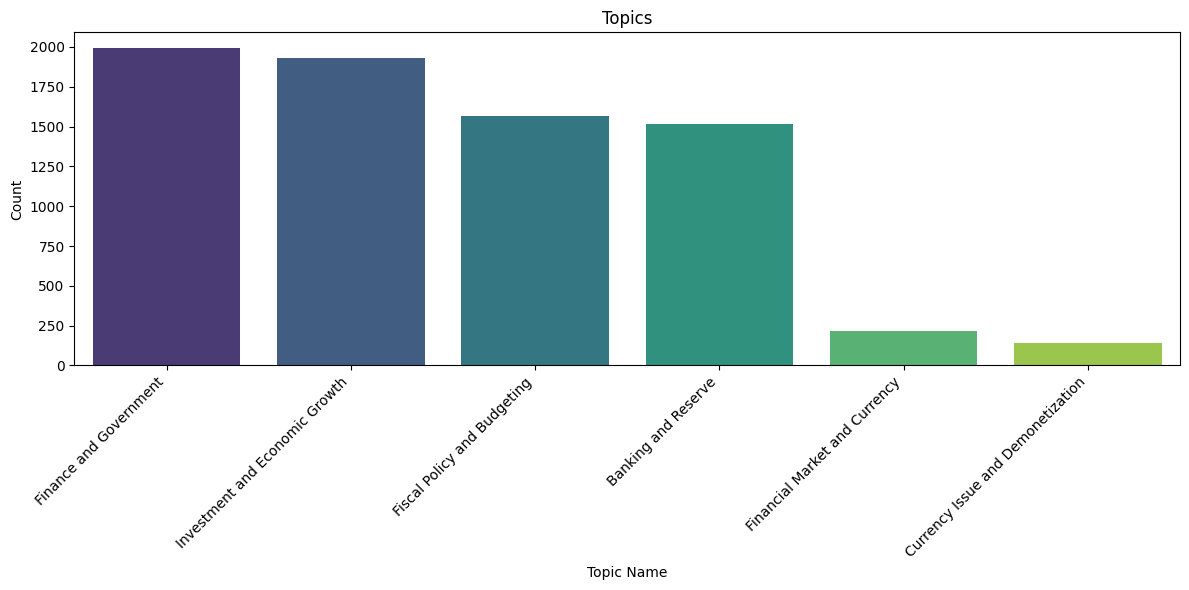

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame and 'topic_name' is the column containing topics
topic_counts = df['topic_name'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')
plt.title('Topics')
plt.xlabel('Topic Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Adjust rotation for better visibility
plt.tight_layout()
plt.savefig("Topics.jpg")
plt.show()


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

<ipython-input-6-b9c6864122be>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
label_encoder = LabelEncoder()
df['deberta_label'] = label_encoder.fit_transform(df['deberta_label'])

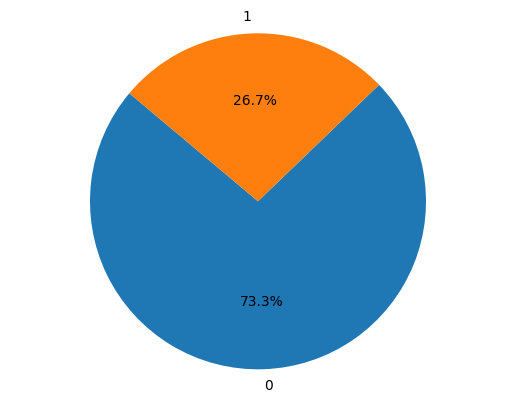

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'bert_label' is a categorical column in your DataFrame
labels = df['deberta_label'].value_counts().index
sizes = df['deberta_label'].value_counts().values

# Plotting the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart
plt.show()

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Label Mapping:", label_mapping)

Label Mapping: {'negative': 0, 'positive': 1}


In [ ]:
# Split the data into training and testing based on the date
train_data_chunk = df[df['Date'] < '2020-08-01']
test_data_chunk = df[df['Date'] >= '2020-08-01']

# Define the features and labels
X_train = train_data_chunk['new_content']
y_train_resampled = train_data_chunk['deberta_label']
X_test = test_data_chunk['new_content']
y_test = test_data_chunk['deberta_label']

In [ ]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train_resampled),
                                        y = y_train_resampled
                                    )
class_weights = dict(zip(np.unique(y_train_resampled), class_weights))
class_weights

{0: 0.6825961324738831, 1: 1.8691418137553257}

In [ ]:
label_counts = test_data_chunk['deberta_label'].value_counts()

print("Label Counts:")
print(label_counts)

Label Counts:
0    899
1    323
Name: deberta_label, dtype: int64


Random Forest

In [ ]:
text_vectorizer = TfidfVectorizer(max_features=1000,ngram_range=(1,2))
X_train_text_features_resampled = text_vectorizer.fit_transform(train_data_chunk['new_content']).toarray()
X_test_text_features = text_vectorizer.transform(test_data_chunk['new_content']).toarray()
# smote = SMOTE(random_state=42)
# X_train_text_features_resampled, y_train_resampled = smote.fit_resample(X_train_text_features, y_train)

# Step 2: Apply Time Series Cross-Validation with Random Forest
tscv = TimeSeriesSplit(n_splits=3, max_train_size=None)

# Define the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, class_weight = class_weights)

# Initialize arrays to store results
res_vec = np.zeros((3, 1))
prv = np.zeros((len(train_data_chunk), 3))

# Initialize DataFrame to store probability predictions
probabilities_df = pd.DataFrame()

for ii, (id0, id1) in enumerate(tscv.split(X_train_text_features_resampled)):
    X_train_fold, X_val_fold = X_train_text_features_resampled[id0], X_train_text_features_resampled[id1]
    y_train_fold, y_val_fold = y_train_resampled.iloc[id0], y_train_resampled.iloc[id1]

    # Train Random Forest model with the best hyperparameters
    rf_model.fit(X_train_fold, y_train_fold)

    # Save probability predictions for the entire dataset
    probabilities = rf_model.predict_proba(X_train_text_features_resampled)

    # Save probability predictions for each class in the DataFrame
    for class_index in range(2):
        probabilities_df[f'Fold_{ii + 1}_Class_{class_index}'] = probabilities[:, class_index]

    # Validation score
    val_preds = rf_model.predict(X_val_fold)
    score = np.round(accuracy_score(y_val_fold, val_preds), 4)
    res_vec[ii] = score
    print("Validation score: " + str(score))

# Train Random Forest model on the entire dataset
rf_model.fit(X_train_text_features_resampled, y_train_resampled)

# Predict on the test set only once
test_probabilities = rf_model.predict_proba(X_test_text_features)
test_pred_rf = rf_model.predict(X_test_text_features)
# Save probability predictions for each class in the test_data_chunk DataFrame
for class_index in range(2):
    test_data_chunk[f'Predicted_Probability_Class_{class_index}'] = test_probabilities[:, class_index]

# Optionally, you can also add the predicted class to the test_data_chunk DataFrame
test_data_chunk['Predicted_Class'] = rf_model.predict(X_test_text_features)


Validation score: 0.7414
Validation score: 0.7713
Validation score: 0.7322


<ipython-input-13-2dad4b343e9d>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_chunk[f'Predicted_Probability_Class_{class_index}'] = test_probabilities[:, class_index]
<ipython-input-13-2dad4b343e9d>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_chunk[f'Predicted_Probability_Class_{class_index}'] = test_probabilities[:, class_index]
<ipython-input-13-2dad4b343e9d>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [ ]:
from sklearn.metrics import classification_report
classification_rep = classification_report(test_data_chunk['deberta_label'], test_pred_rf)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.98      0.85       899
           1       0.66      0.12      0.20       323

    accuracy                           0.75      1222
   macro avg       0.71      0.55      0.53      1222
weighted avg       0.73      0.75      0.68      1222



Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
# Define the Logistic Regression model
lr_model = LogisticRegression(random_state=42, class_weight = class_weights)

# Initialize arrays to store results
res_vec_lr = np.zeros((3, 1))
prv_lr = np.zeros((len(train_data_chunk), 3))

# Initialize DataFrame to store probability predictions
probabilities_df_lr = pd.DataFrame()

for ii, (id0, id1) in enumerate(tscv.split(X_train_text_features_resampled)):
    X_train_fold, X_val_fold = X_train_text_features_resampled[id0], X_train_text_features_resampled[id1]
    y_train_fold, y_val_fold = y_train_resampled.iloc[id0], y_train_resampled.iloc[id1]

    # Train Logistic Regression model
    lr_model.fit(X_train_fold, y_train_fold)

    # Make predictions on validation set for Logistic Regression
    val_preds_lr = lr_model.predict(X_val_fold)
    # prv_lr[:, ii] = lr_model.predict(X_train_text_features_resampled)
    probabilities_lr = lr_model.predict_proba(X_train_text_features_resampled)[:, 1]
    probabilities_df_lr[f'Fold_{ii + 1}'] = probabilities_lr
    score_lr = np.round(accuracy_score(y_val_fold, val_preds_lr), 4)
    res_vec_lr[ii] = score_lr
    print("Logistic Regression Validation score: " + str(score_lr))

# Final training on the entire dataset for Logistic Regression
lr_model.fit(X_train_text_features_resampled, y_train_resampled)

# Predict on the test set only once for Logistic Regression
test_preds_lr = lr_model.predict(X_test_text_features)
test_probabilities_lr = lr_model.predict_proba(X_test_text_features)[:, 1]

# Save predictions and probabilities to the test_data_chunk DataFrame
test_data_chunk['Predicted_Class_LR'] = test_preds_lr
test_data_chunk['Predicted_Probability_LR'] = test_probabilities_lr


Logistic Regression Validation score: 0.6736
Logistic Regression Validation score: 0.7049
Logistic Regression Validation score: 0.6567


<ipython-input-15-3ab1e6903d12>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_chunk['Predicted_Class_LR'] = test_preds_lr
<ipython-input-15-3ab1e6903d12>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_chunk['Predicted_Probability_LR'] = test_probabilities_lr


In [ ]:
classification_rep_lr = classification_report(test_data_chunk['deberta_label'], test_preds_lr)
print("Classification Report:\n", classification_rep_lr)

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.70      0.77       899
           1       0.45      0.69      0.55       323

    accuracy                           0.70      1222
   macro avg       0.66      0.70      0.66      1222
weighted avg       0.75      0.70      0.71      1222



SVM

In [ ]:
from sklearn.preprocessing import StandardScaler
# Define the SVM model
svm_model = SVC(probability=True, random_state=42,class_weight=class_weights)

# Initialize arrays to store results
res_vec_svm = np.zeros((3, 1))
prv_svm = np.zeros((len(train_data_chunk), 3))

# Initialize DataFrame to store probability predictions
probabilities_df_svm = pd.DataFrame()


for ii, (id0, id1) in enumerate(tscv.split(X_train_text_features_resampled)):
    X_train_fold, X_val_fold = X_train_text_features_resampled[id0], X_train_text_features_resampled[id1]
    y_train_fold, y_val_fold = y_train_resampled.iloc[id0], y_train_resampled.iloc[id1]

    # Train SVM model
    svm_model.fit(X_train_fold, y_train_fold)

    # Make predictions on validation set for SVM
    val_preds_svm = svm_model.predict(X_val_fold)
    # prv_svm[:, ii] = svm_model.predict(X_train_text_features)
    probabilities_svm = svm_model.predict_proba(X_train_text_features_resampled)[:, 1]
    probabilities_df_svm[f'Fold_{ii + 1}'] = probabilities_svm
    score_svm = np.round(accuracy_score(y_val_fold, val_preds_svm), 4)
    res_vec_svm[ii] = score_svm
    print("SVM Validation score: " + str(score_svm))

# Final training on the entire dataset for SVM
svm_model.fit(X_train_text_features_resampled, y_train_resampled)

# Predict on the test set only once for SVM
test_preds_svm = svm_model.predict(X_test_text_features)
test_probabilities_svm = svm_model.predict_proba(X_test_text_features)[:, 1]

# Save predictions and probabilities to the test_data_chunk DataFrame
test_data_chunk['Predicted_Class_SVM'] = test_preds_svm
test_data_chunk['Predicted_Probability_SVM'] = test_probabilities_svm


SVM Validation score: 0.7107
SVM Validation score: 0.7433
SVM Validation score: 0.7016


<ipython-input-17-9039327665f0>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_chunk['Predicted_Class_SVM'] = test_preds_svm
<ipython-input-17-9039327665f0>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_chunk['Predicted_Probability_SVM'] = test_probabilities_svm


In [ ]:
classification_rep_svm = classification_report(test_data_chunk['deberta_label'], test_preds_svm)
print("Classification Report:\n", classification_rep_svm)

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.81       899
           1       0.50      0.63      0.56       323

    accuracy                           0.74      1222
   macro avg       0.68      0.70      0.69      1222
weighted avg       0.76      0.74      0.75      1222



KNN

In [ ]:
# Define the KNN model
knn_model = KNeighborsClassifier()

# Initialize arrays to store results
res_vec_knn = np.zeros((3, 1))
prv_knn = np.zeros((len(train_data_chunk), 3))

# Initialize DataFrame to store probability predictions
probabilities_df_knn = pd.DataFrame()

for ii, (id0, id1) in enumerate(tscv.split(X_train_text_features_resampled)):
    X_train_fold, X_val_fold = X_train_text_features_resampled[id0], X_train_text_features_resampled[id1]
    y_train_fold, y_val_fold = y_train_resampled.iloc[id0], y_train_resampled.iloc[id1]

    # Train KNN model
    knn_model.fit(X_train_fold, y_train_fold)

    # Make predictions on validation set for KNN
    val_preds_knn = knn_model.predict(X_val_fold)
    #prv_knn[:, ii] = knn_model.predict(X_train_text_features_resampled)

    # KNN doesn't provide probability estimates directly, so we'll use predict_proba for multiclass
    probabilities_knn = knn_model.predict_proba(X_val_fold)

    # Save probability predictions for the entire dataset
    for class_idx in range(probabilities_knn.shape[1]):
        probabilities_df_knn[f'Fold_{ii + 1}_Class_{class_idx}'] = probabilities_knn[:, class_idx]

    score_knn = np.round(accuracy_score(y_val_fold, val_preds_knn), 4)
    res_vec_knn[ii] = score_knn
    print("KNN Validation score: " + str(score_knn))

# Final training on the entire dataset for KNN
knn_model.fit(X_train_text_features_resampled, y_train_resampled)

# Predict on the test set only once for KNN
test_preds_knn = knn_model.predict(X_test_text_features)
test_probabilities_knn = knn_model.predict_proba(X_test_text_features)

# Save predictions and probabilities to the test_data_chunk DataFrame
test_data_chunk['Predicted_Class_KNN'] = test_preds_knn
for class_idx in range(test_probabilities_knn.shape[1]):
    test_data_chunk[f'Prob_Class_{class_idx}_KNN'] = test_probabilities_knn[:, class_idx]


KNN Validation score: 0.6554
KNN Validation score: 0.6906
KNN Validation score: 0.6847


<ipython-input-19-27022472c937>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_chunk['Predicted_Class_KNN'] = test_preds_knn
<ipython-input-19-27022472c937>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_chunk[f'Prob_Class_{class_idx}_KNN'] = test_probabilities_knn[:, class_idx]
<ipython-input-19-27022472c937>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [ ]:
classification_rep_knn = classification_report(test_data_chunk['deberta_label'], test_preds_knn)
print("Classification Report:\n", classification_rep_knn)

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77       899
           1       0.40      0.46      0.43       323

    accuracy                           0.67      1222
   macro avg       0.60      0.60      0.60      1222
weighted avg       0.69      0.67      0.68      1222



Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Define the Naive Bayes model
nb_model = MultinomialNB()

# Initialize arrays to store results
res_vec_nb = np.zeros((3, 1))
prv_nb = np.zeros((len(train_data_chunk), 3))

# Initialize DataFrame to store probability predictions
probabilities_df_nb = pd.DataFrame()

for ii, (id0, id1) in enumerate(tscv.split(X_train_text_features_resampled)):
    X_train_fold, X_val_fold = X_train_text_features_resampled[id0], X_train_text_features_resampled[id1]
    y_train_fold, y_val_fold = y_train_resampled.iloc[id0], y_train_resampled.iloc[id1]

    # Train Naive Bayes model
    nb_model.fit(X_train_fold, y_train_fold)

    # Make predictions on validation set for Naive Bayes
    val_preds_nb = nb_model.predict(X_val_fold)
    # prv_nb[:, ii] = nb_model.predict(X_train_text_features)
    probabilities_nb = nb_model.predict_proba(X_train_text_features_resampled)[:, 1]
    probabilities_df_nb[f'Fold_{ii + 1}'] = probabilities_nb
    score_nb = np.round(accuracy_score(y_val_fold, val_preds_nb), 4)
    res_vec_nb[ii] = score_nb
    print("Naive Bayes Validation score: " + str(score_nb))

# Final training on the entire dataset for Naive Bayes
nb_model.fit(X_train_text_features_resampled, y_train_resampled)

# Predict on the test set only once for Naive Bayes
test_preds_nb = nb_model.predict(X_test_text_features)
test_probabilities_nb = nb_model.predict_proba(X_test_text_features)[:, 1]

# Save predictions and probabilities to the test_data_chunk DataFrame
test_data_chunk['Predicted_Class_NB'] = test_preds_nb
test_data_chunk['Predicted_Probability_NB'] = test_probabilities_nb


Naive Bayes Validation score: 0.7225
Naive Bayes Validation score: 0.757
Naive Bayes Validation score: 0.7336


<ipython-input-21-05586804b9b1>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_chunk['Predicted_Class_NB'] = test_preds_nb
<ipython-input-21-05586804b9b1>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_chunk['Predicted_Probability_NB'] = test_probabilities_nb


In [ ]:
classification_rep_nb = classification_report(test_data_chunk['deberta_label'], test_preds_nb)
print("Classification Report:\n", classification_rep_nb)

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84       899
           1       0.52      0.29      0.38       323

    accuracy                           0.74      1222
   macro avg       0.65      0.60      0.61      1222
weighted avg       0.71      0.74      0.71      1222



Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42, class_weight=class_weights)

# Initialize arrays to store results
res_vec_dt = np.zeros((3, 1))
prv_dt = np.zeros((len(train_data_chunk), 3))

# Initialize DataFrame to store probability predictions
probabilities_df_dt = pd.DataFrame()

for ii, (id0, id1) in enumerate(tscv.split(X_train_text_features_resampled)):
    X_train_fold, X_val_fold = X_train_text_features_resampled[id0], X_train_text_features_resampled[id1]
    y_train_fold, y_val_fold = y_train_resampled.iloc[id0], y_train_resampled.iloc[id1]

    # Train Decision Tree model
    dt_model.fit(X_train_fold, y_train_fold)

    # Make predictions on validation set for Decision Tree
    val_preds_dt = dt_model.predict(X_val_fold)
    #prv_dt[:, ii] = dt_model.predict(X_train_text_features_resampled)

    # Decision Trees don't provide probability estimates directly, so we'll use predict_proba
    val_probs_dt = dt_model.predict_proba(X_val_fold)

    # Save probability predictions for the entire dataset
    probabilities_df_dt[f'Fold_{ii + 1}_Class_0'] = val_probs_dt[:, 0]
    # probabilities_df_dt[f'Fold_{ii + 1}_Class_1'] = val_probs_dt[:, 1]
    # probabilities_df_dt[f'Fold_{ii + 1}_Class_2'] = val_probs_dt[:, 2]

    score_dt = np.round(accuracy_score(y_val_fold, val_preds_dt), 4)
    res_vec_dt[ii] = score_dt
    print("Decision Tree Validation score: " + str(score_dt))

# Final training on the entire dataset for Decision Tree
dt_model.fit(X_train_text_features_resampled, y_train_resampled)

# Predict on the test set only once for Decision Tree
test_preds_dt = dt_model.predict(X_test_text_features)
test_probabilities_dt = dt_model.predict_proba(X_test_text_features)

# Save predictions and probabilities to the test_data_chunk DataFrame
test_data_chunk['Predicted_Class_DT'] = test_preds_dt
test_data_chunk['Prob_Class_0_DT'] = test_probabilities_dt[:, 0]
# test_data_chunk['Prob_Class_1_DT'] = test_probabilities_dt[:, 1]
# test_data_chunk['Prob_Class_2_DT'] = test_probabilities_dt[:, 2]


Decision Tree Validation score: 0.6436
Decision Tree Validation score: 0.6625
Decision Tree Validation score: 0.645


<ipython-input-23-11258ddea4a1>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_chunk['Predicted_Class_DT'] = test_preds_dt
<ipython-input-23-11258ddea4a1>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_chunk['Prob_Class_0_DT'] = test_probabilities_dt[:, 0]


In [ ]:
classification_rep_dt = classification_report(test_data_chunk['deberta_label'], test_preds_dt)
print("Classification Report:\n", classification_rep_dt)

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.77       899
           1       0.38      0.39      0.38       323

    accuracy                           0.67      1222
   macro avg       0.58      0.58      0.58      1222
weighted avg       0.67      0.67      0.67      1222



In [ ]:
y_train_resampled

0       0
1       0
2       0
3       1
4       0
       ..
6246    0
6275    0
6276    0
6277    0
6278    0
Name: deberta_label, Length: 6142, dtype: int64

In [ ]:
from xgboost import XGBClassifier
# Define the XGBoost model
xgb_model = XGBClassifier(random_state=42,sample_weight=class_weights)
# Initialize arrays to store results
res_vec_xgb = np.zeros((3, 1))
prv_xgb = np.zeros((len(train_data_chunk), 3))

# Initialize DataFrame to store probability predictions
probabilities_df_xgb = pd.DataFrame()

for ii, (id0, id1) in enumerate(tscv.split(X_train_text_features_resampled)):
    X_train_fold, X_val_fold = X_train_text_features_resampled[id0], X_train_text_features_resampled[id1]
    y_train_fold, y_val_fold = y_train_resampled.iloc[id0], y_train_resampled.iloc[id1]

    # Train XGBoost model
    xgb_model.fit(X_train_fold, y_train_fold)

    # Make predictions on validation set
    val_preds_xgb = xgb_model.predict(X_val_fold)
    #prv_xgb[:, ii] = xgb_model.predict(X_train_text_features_resampled)

    # Save probability predictions for the entire dataset
    probabilities_xgb = xgb_model.predict_proba(X_train_text_features_resampled)[:, 1]
    probabilities_df_xgb[f'Fold_{ii + 1}'] = probabilities_xgb

    # Validation score
    score_xgb = np.round(accuracy_score(y_val_fold, val_preds_xgb), 4)
    res_vec_xgb[ii] = score_xgb
    print("XGBoost Validation score: " + str(score_xgb))

# Final training on the entire dataset for XGBoost
xgb_model.fit(X_train_text_features_resampled, y_train_resampled)

# Predict on the test set only once for XGBoost
test_preds_xgb = xgb_model.predict(X_test_text_features)
test_probabilities_xgb = xgb_model.predict_proba(X_test_text_features)[:, 1]

# Save predictions and probabilities to the test_data_chunk DataFrame
test_data_chunk['Predicted_Class_XGB'] = test_preds_xgb
test_data_chunk['Predicted_Probability_XGB'] = test_probabilities_xgb


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:59:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sample_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Validation score: 0.7238


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:59:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sample_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Validation score: 0.7459


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:59:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sample_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Validation score: 0.7225


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:00:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sample_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
classification_rep_xgb = classification_report(test_data_chunk['deberta_label'], test_preds_xgb)
print("Classification Report:\n", classification_rep_xgb)

In [ ]:
# Get feature names from the TfidfVectorizer
feature_names = text_vectorizer.get_feature_names_out()

# Zip feature names and importance scores, then sort by importance in descending order
feature_importance_tuples = sorted(zip(feature_names, xgb_model.feature_importances_), key=lambda x: x[1], reverse=True)

# Print the top 10 features
for feature, importance in feature_importance_tuples[:10]:
    print('{}: {}'.format(feature, importance))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Get feature names from the TfidfVectorizer (bigrams)
feature_names = text_vectorizer.get_feature_names_out()

# Zip feature names and importance scores, then sort by importance in descending order
feature_importance_tuples = sorted(zip(feature_names, xgb_model.feature_importances_), key=lambda x: x[1], reverse=True)

# Extract top 10 features and their importance scores
top_features, top_importances = zip(*feature_importance_tuples[:10])

# Reverse the order to have descending bars
top_features = top_features[::-1]
top_importances = top_importances[::-1]

# Create a range of colors from light to dark
colors = plt.cm.Blues(np.linspace(0.2, 1, len(top_features)))

# Plot the horizontal bar graph with progressively lighter colors
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color=colors)
plt.xlabel('Importance Score')
plt.title('Top 10 Bigrams in XGBoost Model')
plt.show()


In [ ]:
# print(df[df['new_content'] == 'economic fundamental slowly slipping high inflation volatile manufacturing service number threatening growth' ].index.values)

In [ ]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

idx = df.index[233]
c = make_pipeline(text_vectorizer, rf_model)
class_names = ['positive', 'negative', 'neutral']
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(
    df["new_content"][idx],
    c.predict_proba,
    num_features=10
)
explanation_list = exp.as_list()
print("Text:")
print(df["new_content"][idx])
print("\nExplanation:")
for word, weight in explanation_list:
    print(f"{word}: {weight}")
print("Probability (Positive) =", c.predict_proba([df["new_content"][idx]])[0, 0])
print("Probability (Negative) =", c.predict_proba([df["new_content"][idx]])[0, 1])

print("True Class is:", class_names[df["deberta_label"][idx]])



In [ ]:
exp.show_in_notebook(text=train_data_chunk["new_content"][idx], labels=(1,))

In [ ]:
models_list = [rf_model, lr_model, svm_model, knn_model, nb_model, xgb_model]

In [ ]:
models_list = [rf_model, lr_model, svm_model, knn_model, nb_model, xgb_model]
results_df = test_data_chunk.copy()

# Iterate through each model
for model in models_list:
    model_name = type(model).__name__  # Get the name of the model
    # Predict probabilities for each class
    y_proba = model.predict_proba(X_test_text_features)

    # Store the probabilities in a new column with the model's name
    for i, class_name in enumerate(model.classes_):
        results_df[f'{model_name}_{class_name}_Probability'] = y_proba[:, i]


In [ ]:
results_df.columns

Index(['Headline', 'Summary', 'Content', 'Category', 'Date_Time', 'type_cat',
       'Date', 'target', 'assigned_topic', 'topic_name', 'new_content',
       'new_summary', 'new_headline', 'Combined_Text', 'positive_probability',
       'neutral_probability', 'negative_probability', 'pos_prob', 'neg_prob',
       'roberta_label', 'positive_probability_r', 'neutral_probability_r',
       'negative_probability_r', 'pos_prob_r', 'neg_prob_r', 'bert_label',
       'positive_probability_d', 'neutral_probability_d',
       'negative_probability_d', 'pos_prob_d', 'neg_prob_d', 'deberta_label',
       'finvader', 'finvader_label', 'text_id',
       'Predicted_Probability_Class_0', 'Predicted_Probability_Class_1',
       'Predicted_Class', 'Predicted_Class_LR', 'Predicted_Probability_LR',
       'Predicted_Class_SVM', 'Predicted_Probability_SVM',
       'Predicted_Class_KNN', 'Prob_Class_0_KNN', 'Prob_Class_1_KNN',
       'Predicted_Class_NB', 'Predicted_Probability_NB', 'Predicted_Class_DT',
  

In [ ]:
results_df['Date'] = pd.to_datetime(results_df['Date'])
results_df.set_index('Date', inplace=True)
df_monthly = results_df[['pos_prob_d','neg_prob_d','XGBClassifier_0_Probability','XGBClassifier_1_Probability','LogisticRegression_1_Probability','RandomForestClassifier_1_Probability','SVC_1_Probability']].resample('QS').mean()
df_monthly.reset_index(inplace = True)

In [ ]:
df_monthly.head()

,Date,pos_prob_d,neg_prob_d,XGBClassifier_0_Probability,XGBClassifier_1_Probability,LogisticRegression_1_Probability,RandomForestClassifier_1_Probability,SVC_1_Probability
0,2020-07-01,0.407570,0.592430,0.716427,0.283573,0.506408,0.294355,0.326219
1,2020-10-01,0.368149,0.631851,0.767560,0.232439,0.440222,0.274691,0.280308
2,2021-01-01,0.319994,0.680006,0.804800,0.195200,0.400936,0.246853,0.231763
3,2021-04-01,0.300940,0.699060,0.746902,0.253098,0.438317,0.280901,0.267304
4,2021-07-01,0.300732,0.699268,0.799000,0.201000,0.409464,0.268396,0.241570


In [ ]:
df_monthly.set_index('Date', inplace=True)
window_size = 3  # You can adjust the window size as needed
df_monthly_smoothed = df_monthly.rolling(window=window_size).mean()
# Drop rows with NaN values (due to the rolling mean)
df_monthly_smoothed.dropna(inplace=True)

# Reset the index for plotting
df_monthly_smoothed.reset_index(inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler
numerical_columns = ['pos_prob_d','neg_prob_d','XGBClassifier_0_Probability','XGBClassifier_1_Probability','LogisticRegression_1_Probability',
                     'RandomForestClassifier_1_Probability','SVC_1_Probability']
scaler = StandardScaler()
df_monthly_smoothed[numerical_columns] = scaler.fit_transform(df_monthly_smoothed[numerical_columns])

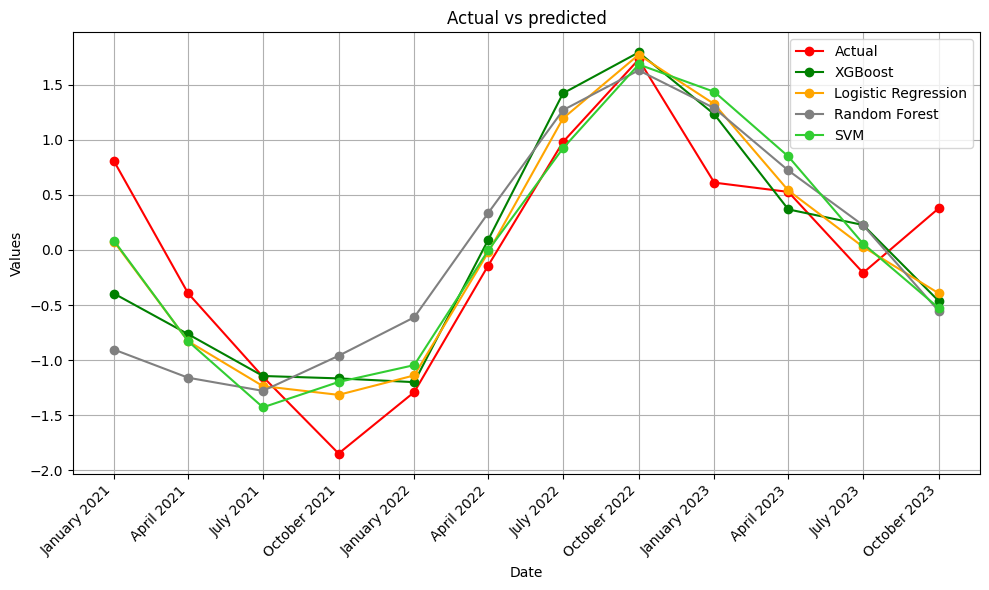

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

plt.plot(df_monthly_smoothed['Date'], df_monthly_smoothed['pos_prob_d'], marker='o',linestyle='-',color='red', label='Actual')
plt.plot(df_monthly_smoothed['Date'], df_monthly_smoothed['XGBClassifier_1_Probability'], marker='o', linestyle='-', color='green', label='XGBoost')
# # #plt.plot(df_monthly_smoothed['Date'], df_monthly_smoothed['K-NN_2_Probability'], marker='o', linestyle='-', color='purple', label='K-NNy')
plt.plot(df_monthly_smoothed['Date'], df_monthly_smoothed['LogisticRegression_1_Probability'], marker='o', linestyle='-', color='orange', label='Logistic Regression')
# #plt.plot(df_monthly_smoothed['Date'], df_monthly_smoothed['Naive Bayes_2_Probability'], marker='o', linestyle='-', color='pink', label='Naive Bayes')
plt.plot(df_monthly_smoothed['Date'], df_monthly_smoothed['RandomForestClassifier_1_Probability'], marker='o', linestyle='-', color='gray', label='Random Forest')
plt.plot(df_monthly_smoothed['Date'], df_monthly_smoothed['SVC_1_Probability'], marker='o', linestyle='-', color='limegreen', label='SVM')

plt.xticks(df_monthly_smoothed['Date'], df_monthly_smoothed['Date'].dt.strftime('%B %Y'), rotation=45, ha='right')
plt.title('Actual vs predicted')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Linegraph.jpg')
plt.show()


In [ ]:
df_monthly.to_csv("Chunk.csv")